In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append("../../")

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")
%matplotlib inline

['/Users/franciscoacosta/Desktop/code/abn/abn/notebooks', '/Users/franciscoacosta/opt/anaconda3/envs/abn1/lib/python39.zip', '/Users/franciscoacosta/opt/anaconda3/envs/abn1/lib/python3.9', '/Users/franciscoacosta/opt/anaconda3/envs/abn1/lib/python3.9/lib-dynload', '', '/Users/franciscoacosta/opt/anaconda3/envs/abn1/lib/python3.9/site-packages', '/Users/franciscoacosta/.local/lib/python3.9/site-packages', '../../']


In [2]:
import numpy as np
import torch
import torch.optim as optim
import pandas as pd
from abn.models.spherical_vae import SphericalVAE
from abn.trainer.svae_trainer import SphericalVAETrainer
from abn.datasets.cyclic_walk import CyclicWalk, CyclicWalkLoader

/Users/franciscoacosta/opt/anaconda3/envs/abn1/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Hyperspherical VAE

## Load Dataset

40it [02:05,  3.14s/it]


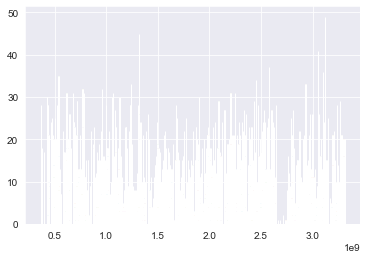

In [3]:
path = "../data/expt34.mat" # CHANGE TO YOUR DATA LOCATION IF NEEDED
time_bin = 1000000
dataset = CyclicWalk(path=path, randomize_pairs=True, time_bin=time_bin, velocity_threshold=0.3)

## Normalize the Data

Note: Different normalization schemes have a *HUGE* impact on the training procedure.
Options that should be explored include:
- Z-scoring each neuron's response across the entire dataset
- Setting min of the entire dataset to 0 and max to 1
- Setting the norm of each neural state vector to 1

They are each implemented below. Uncomment options to try them out

In [16]:
"""
Z-Scoring
"""
# dataset.data = dataset.data - dataset.data.mean(axis=-1, keepdim=True)
# dataset.data = dataset.data / dataset.data.std(axis=-1, keepdim=True)
# print(dataset.data.std(axis=-1))

In [4]:
"""
Min 0 Max 1
"""
dataset.data = dataset.data - dataset.data.min()
dataset.data = dataset.data / dataset.data.max()

In [ ]:
"""
Unit Norm
"""
# dataset.data = dataset.data / torch.linalg.norm(dataset.data, dim=-1, keepdim=True)
# print(torch.linalg.norm(dataset.data, dim=-1))

## Train Val Split and Generate Batches

In [5]:
data_loader = CyclicWalkLoader(batch_size=20)
data_loader.load(dataset)

## Construct Model

In [6]:
model = SphericalVAE(input_dim=40,
                     encoder_dims=[40, 20, 10],
                     latent_dim=2,
                     distribution="vmf")

optimizer = optim.Adam(model.parameters(), lr=0.001)

trainer = SphericalVAETrainer(model=model, optimizer=optimizer)

## Train Model

In [7]:
trainer.train(data_loader, 1000)

/Users/franciscoacosta/opt/anaconda3/envs/abn1/lib/python3.9/site-packages/torch/distributions/distribution.py:44: UserWarning: <class 'hyperspherical_vae.distributions.hyperspherical_uniform.HypersphericalUniform'> does not define `arg_constraints`. Please set `arg_constraints = {}` or initialize the distribution with `validate_args=False` to turn off validation.
  warnings.warn(f'{self.__class__} does not define `arg_constraints`. ' +


Epoch 0 ||  N Examples 0 || Train Total Loss 24.06489 || Validation Total Loss 19.08462
Epoch 1 ||  N Examples 890 || Train Total Loss 13.94066 || Validation Total Loss 10.94423
Epoch 2 ||  N Examples 1780 || Train Total Loss 10.62982 || Validation Total Loss 10.43969
Epoch 3 ||  N Examples 2670 || Train Total Loss 10.48052 || Validation Total Loss 10.45718
Epoch 4 ||  N Examples 3560 || Train Total Loss 10.45629 || Validation Total Loss 10.48212
Epoch 5 ||  N Examples 4450 || Train Total Loss 10.44818 || Validation Total Loss 10.43749
Epoch 6 ||  N Examples 5340 || Train Total Loss 10.42598 || Validation Total Loss 10.40721
Epoch 7 ||  N Examples 6230 || Train Total Loss 10.40833 || Validation Total Loss 10.37168
Epoch 8 ||  N Examples 7120 || Train Total Loss 10.38248 || Validation Total Loss 10.33604
Epoch 9 ||  N Examples 8010 || Train Total Loss 10.35187 || Validation Total Loss 10.38777
Epoch 10 ||  N Examples 8900 || Train Total Loss 10.34256 || Validation Total Loss 10.37082
Ep

## Visualize Latent Space

In [8]:
with torch.no_grad():
    (z_mean, z_var), (q_z, p_z), z = model.to_latent(dataset.data)

In [9]:
df = pd.DataFrame({"z0": z[:, 0], 
                    "z1": z[:, 1], 
                    "pos": (dataset.pos + dataset.angle) % (2 * np.pi)})

<AxesSubplot:xlabel='z0', ylabel='z1'>

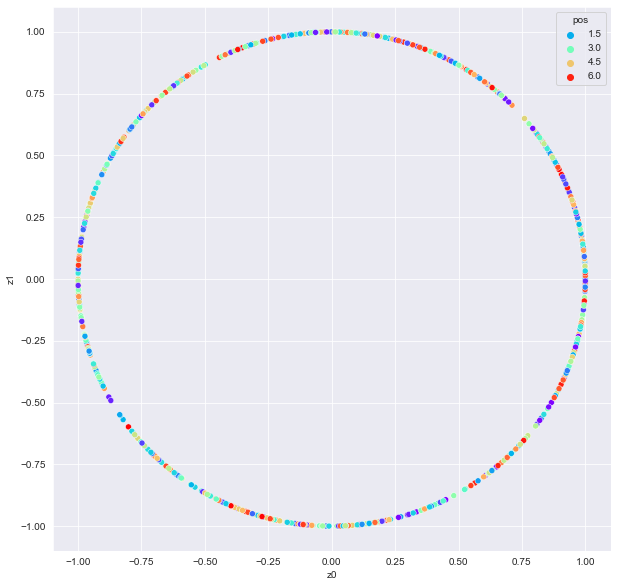

In [10]:
plt.figure(figsize=(10, 10))
sns.scatterplot(x="z0", y="z1", hue="pos", data=df, palette="rainbow")